In [2]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [3]:
train_data = pd.read_csv('train_data.csv', low_memory=False)

In [4]:
df5 = train_data[train_data['overall']==5].sample(frac=0.123, random_state=42)
df5.shape

(56763, 11)

In [5]:
df4 = train_data[train_data['overall']==4].sample(frac=0.36, random_state=42)
df4.shape

(56345, 11)

In [6]:
df3 = train_data[train_data['overall']==3].sample(frac=0.7, random_state=42)
df3.shape

(56867, 11)

In [7]:
df2 = train_data[train_data['overall']==2].sample(frac=1, random_state=42)
df2.shape

(56756, 11)

In [8]:
df1 = train_data[train_data['overall']==1].sample(frac=0.68, random_state=42)
df1.shape

(56406, 11)

In [9]:
df = pd.concat([df1,df2,df3,df4,df5],axis=0)
df

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime
162556,1,NaN,False,2016-01-03,A2RN50HQ5YYVVT,B00B5Q7ACE,"{'Capacity:': ' No Size', 'Style:': ' 4-Bay En...",Sid Priyadarshi,"This is a really slow product, and some featur...","Slow drive, multiple timeouts",1451779200
260161,1,NaN,True,2016-09-15,A11P4JMZ8LVCSN,B00INF5IU6,NaN,Tobor,I have purchased 3 pairs overtime. January 20...,Left Side Fails after several months of gentle...,1473897600
546764,1,4,True,2016-12-20,A1C8C8QR0LWPU6,B015PD3HOC,"{'Size:': ' AC5300', 'Style:': ' without exper...",G. Stein,"Hello, I purchase the Nighthawk AC5300 and wor...",Netgear AC5300 X8 not worth it!,1482192000
228563,1,2.0,True,2016-05-09,A29407ZZXMJFIB,B00G9XGAPG,NaN,Gletkin,The 3-pack arrived Saturday and two were insta...,"After Three days: One alive, One dead,and One ...",1462752000
628780,1,9,True,2017-11-04,A2V5HT1V820OV6,B01AWGYE12,{'Size:': ' Wi-Fi'},Cassandra Ketterer,"The projector itself is pretty amazing, HOWEVE...","Lovely Projector, but basically useless becaus...",1509753600
...,...,...,...,...,...,...,...,...,...,...,...
613946,5,NaN,True,2018-02-10,A1VUNVDZ9YI23D,B019VM3GKI,"{'Size:': ' Small (5.5 - 6.7 in)', 'Color:': '...",Vanessa,LOVE!!! I've been so hesitant to buy this beca...,LOVE!!,1518220800
373542,5,6.0,True,2017-01-21,A3139P1HOJI4QP,B00R0DCSSM,{'Size:': ' HAS-10'},Good Guy,"My god, these headphones are fabulous. I just ...",Absolutely fabulous !!,1484956800
203410,5,NaN,True,2016-03-09,A3BHXRBK9B7K9Y,B00E5I7VJG,{'Size:': ' 3 Feet'},Gustav,These are really nicely made cables. They fee...,I love Cable Matters stuff,1457481600
502103,5,NaN,True,2017-12-22,A2TWQTW5YY51GH,B012N3C6OY,{'Color:': ' Blue'},"Manuel Lopez, Jr.",Love it! I have a USB drive that has all my mu...,Switch folders,1513900800


# Preprocessing

In [10]:
TEXT_COLUMN = 'reviewText'
RATING_COLUMN = 'overall'

if TEXT_COLUMN not in df.columns:
    raise ValueError(f"Column '{TEXT_COLUMN}' not found in the dataset. Please check the review text column name.")
if RATING_COLUMN not in df.columns:
    raise ValueError(f"Column '{RATING_COLUMN}' not found in the dataset. Please check the rating column name.")

# Data Cleaning: Handle missing values and ensure 'overall' is integer
# Drop rows where reviewText or overall rating is missing
df.dropna(subset=[TEXT_COLUMN, RATING_COLUMN], inplace=True)

# Convert 'overall' to numeric and then to integer. Coerce errors to NaN and then drop.
df[RATING_COLUMN] = pd.to_numeric(df[RATING_COLUMN], errors='coerce')
df.dropna(subset=[RATING_COLUMN], inplace=True)
df[RATING_COLUMN] = df[RATING_COLUMN].astype(int)

# Filter for valid 1-5 star ratings
df = df[(df[RATING_COLUMN] >= 1) & (df[RATING_COLUMN] <= 5)].copy()

# Map 1-5 ratings to 0-4 for PyTorch CrossEntropyLoss
df['label'] = df[RATING_COLUMN] - 1

print("Filtered Rating Distribution (1-5 stars):")
print(df[RATING_COLUMN].value_counts().sort_index())
print("-" * 30)
print("Mapped Label Distribution (0-4 for PyTorch):")
print(df['label'].value_counts().sort_index())
print("-" * 30)

# Split the dataset
# Stratify by 'label' to ensure similar distribution of 1-5 star ratings in train/test sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

print("\nTrain Label Distribution:")
print(train_df['label'].value_counts().sort_index())
print("\nvalidation Label Distribution:")
print(val_df['label'].value_counts().sort_index())




Filtered Rating Distribution (1-5 stars):
overall
1    56406
2    56756
3    56867
4    56345
5    56763
Name: count, dtype: int64
------------------------------
Mapped Label Distribution (0-4 for PyTorch):
label
0    56406
1    56756
2    56867
3    56345
4    56763
Name: count, dtype: int64
------------------------------

Train Label Distribution:
label
0    45125
1    45405
2    45493
3    45076
4    45410
Name: count, dtype: int64

validation Label Distribution:
label
0    11281
1    11351
2    11374
3    11269
4    11353
Name: count, dtype: int64


# Custom Dataset and DataLoader

In [11]:
class AmazonReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Model and Tokenizer Setup

In [12]:
PRE_TRAINED_MODEL_NAME = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
MAX_LEN = 128 # Adjust based on your average review length. For short reviews, 128 is usually fine.
BATCH_SIZE = 16

train_dataset = AmazonReviewDataset(
    texts=train_df[TEXT_COLUMN].to_numpy(),
    labels=train_df['label'].to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

val_dataset = AmazonReviewDataset(
    texts = val_df[TEXT_COLUMN].to_numpy(),
    labels = val_df['label'].to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)


train_data_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_data_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Model Initialization and Imbalance Handling (Class Weighting)

In [13]:
# Determine the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# num_labels should now be 5 (for 1, 2, 3, 4, 5 stars)
NUM_CLASSES = len(np.unique(df['label'])) # This will be 5 if all 1-5 stars are present after filtering
model = DistilBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME, num_labels=NUM_CLASSES)
model = model.to(device)

# Calculate class weights for imbalanced data (based on 0-4 labels)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print(f"\nClass Weights (for labels 0-4): {class_weights.cpu().numpy()}")

# Optimizer and Loss Function
EPOCHS = 2 # You might need more epochs for convergence with 5 classes and a potentially small dataset
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights) # Apply class weights here




Using device: cuda


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Class Weights (for labels 0-4): [1.003918   0.9977271  0.99579716 1.0050093  0.99761724]


# Training Model

In [14]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler=None):
    model = model.train()
    losses = []
    correct_predictions = 0
    total_samples = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, preds = torch.max(logits, dim=1)

        loss = loss_fn(logits, labels)

        correct_predictions += torch.sum(preds == labels)
        total_samples += labels.size(0)

        losses.append(loss.item())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        if scheduler:
            scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / total_samples, np.mean(losses)

# Evaluation

In [15]:
def eval_model(model, data_loader, loss_fn, device):
    model = model.eval()
    losses = []
    correct_predictions = 0
    total_samples = 0
    all_predictions = []
    all_true_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)

            loss = loss_fn(logits, labels)

            correct_predictions += torch.sum(preds == labels)
            total_samples += labels.size(0)

            losses.append(loss.item())
            all_predictions.extend(preds.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())

    return correct_predictions.double() / total_samples, np.mean(losses), all_predictions, all_true_labels

# Training Loop

In [16]:
history = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []}

print("\nStarting training...")
for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device
    )
    print(f"Train loss: {train_loss:.4f} Train accuracy: {train_acc:.4f}")

    val_acc, val_loss, _, _ = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device
    )
    print(f"Validation loss: {val_loss:.4f} Validation accuracy: {val_acc:.4f}")

    history['train_acc'].append(train_acc.item())
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc.item())
    history['val_loss'].append(val_loss)
    # saving model---------------------------------------
    checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
    }
    torch.save(checkpoint, f"checkpoint_epoch_{epoch}.pth")
    #----------------------------------------------------
print("\nTraining complete!")
final_acc, final_loss, all_predictions, all_true_labels = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device
)

print(f"\nTest Accuracy: {final_acc:.4f}")
print(f"Test Loss: {final_loss:.4f}")

# Generate a classification report
# Target names should be 1-5 (converted back from 0-4 for display)
target_names = [str(i+1) for i in range(NUM_CLASSES)]
print("\nClassification Report:")
# Ensure all_true_labels and all_predictions contain valid labels (0 to NUM_CLASSES-1)
# and handle cases where a class might be missing in test_df due to small sample size
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(np.unique(df['label'])) # Fit on all unique labels from the original df
# Ensure all labels present in true/pred are handled for target_names display
actual_target_names = [str(le.inverse_transform([i])[0] + 1) for i in np.unique(all_true_labels)]
print(classification_report(all_true_labels, all_predictions, target_names=target_names, zero_division=0))


Starting training...

Epoch 1/2
Train loss: 0.9926 Train accuracy: 0.5685
Validation loss: 0.9294 Validation accuracy: 0.6021

Epoch 2/2
Train loss: 0.8607 Train accuracy: 0.6306
Validation loss: 0.9162 Validation accuracy: 0.6108

Training complete!

Test Accuracy: 0.6108
Test Loss: 0.9162

Classification Report:
              precision    recall  f1-score   support

           1       0.69      0.67      0.68     11281
           2       0.50      0.52      0.51     11351
           3       0.52      0.54      0.53     11374
           4       0.63      0.51      0.56     11269
           5       0.72      0.82      0.77     11353

    accuracy                           0.61     56628
   macro avg       0.61      0.61      0.61     56628
weighted avg       0.61      0.61      0.61     56628



# Confusion Matrix and train/validation loss/accuracy plots

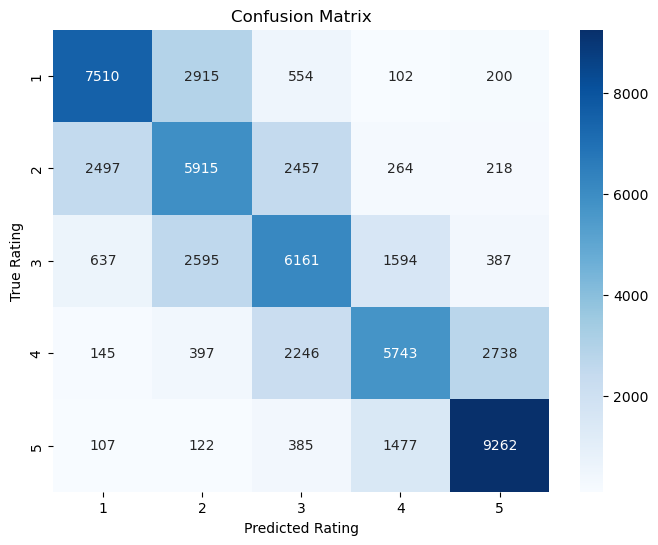

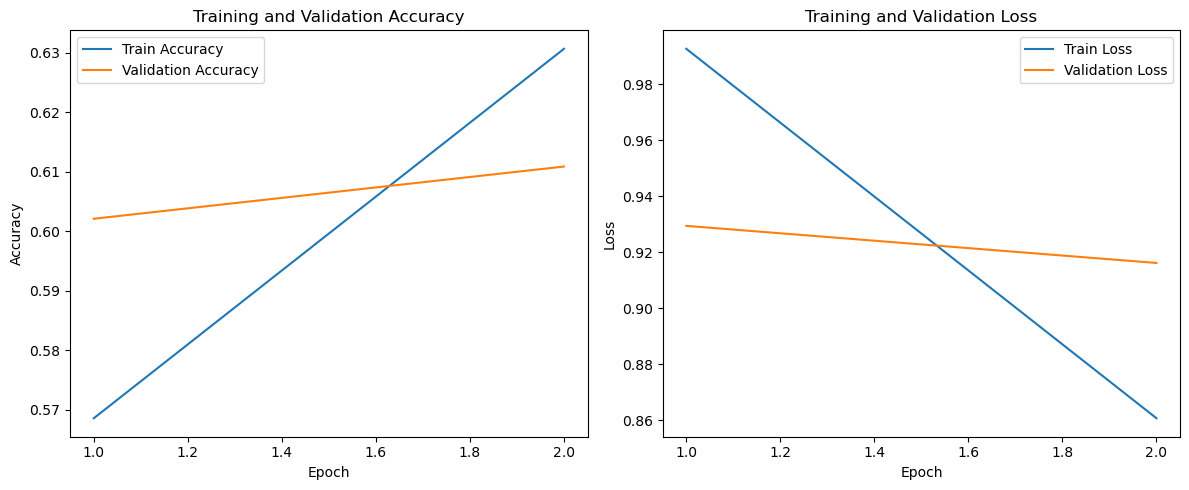

In [17]:
# Confusion Matrix
cm = confusion_matrix(all_true_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Rating')
plt.ylabel('True Rating')
plt.title('Confusion Matrix')
plt.show()

# Plotting training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1,EPOCHS+1),history['train_acc'], label='Train Accuracy')
plt.plot(range(1,EPOCHS+1),history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1,EPOCHS+1),history['train_loss'], label='Train Loss')
plt.plot(range(1,EPOCHS+1),history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# prediction

In [18]:
def predict_rating(text, model, tokenizer, max_len, device, num_classes):
    model.eval()
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_len,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        softmax_probs = torch.nn.functional.softmax(logits, dim=1)
        _, prediction = torch.max(softmax_probs, dim=1)

    predicted_label = prediction.item()
    # Convert back from 0-4 to 1-5 star rating
    predicted_rating = predicted_label + 1

    # Prepare probabilities for each star rating
    probs_dict = {f"{i+1} Star": prob for i, prob in enumerate(softmax_probs.cpu().numpy()[0])}
    return predicted_rating, probs_dict


In [19]:
test_data = pd.read_csv('test_data.csv', low_memory=False)
new_reviews = list(test_data['reviewText'].unique())
predictions = []
for review in new_reviews:
    predicted_rating, probabilities = predict_rating(review, model, tokenizer, MAX_LEN, device, NUM_CLASSES)
    predictions.append(predicted_rating)
pred_df = pd.DataFrame({'predicted' : predictions})
pred_df.to_csv('q2_submission.csv',index=False)